# MMC Laboratorium 6

Autor: Jakub Ostrzołek

## Zadanie 1

### Funkcje ładujące wyniki działania programu `epidemia`

In [28]:
import numpy as np

from __future__ import annotations
from dataclasses import dataclass
from typing import TextIO

BINARY = "./out/ising"


@dataclass
class ExperimentResultMicrocanonical:
    system_energy_mean: float
    ghost_energy_mean: float
    magnetization_mean: float
    temperature: float

    @classmethod
    def from_io(cls, output: TextIO) -> ExperimentResultMicrocanonical:
        lines = [line for line in output.readlines() if "=" in line]
        values = [line.split("=")[1].strip() for line in lines]
        return cls(*map(float, values))

### Funkcja uruchamiająca program `epidemia`

Zmodyfikowałem program `epidemia` tak, żeby przyjmował swoje parametry poprzez argumenty wywołania linii poleceń.

In [29]:
from subprocess import run
from io import StringIO


def run_experiment(
    side: int | None = None,
    energy: int | None = None,
    temperature: float | None = None,
    steps: int | None = None,
) -> TextIO:
    cli_args_dict = {
        "--bok-mapy": side,
        "--energia": energy,
        "--temperatura": temperature,
        "--liczba-krokow": steps,
    }
    cli_args = [
        [key, str(value)] for key, value in cli_args_dict.items() if value is not None
    ]

    command = [BINARY, *(arg for arg_set in cli_args for arg in arg_set)]

    process = run(command, capture_output=True, encoding="UTF-8")
    process.check_returncode()

    return StringIO(process.stdout)


def run_experiment_microcanonical(
    side: int = 10,
    energy: int = -184,
    steps: int = 1000,
) -> ExperimentResultMicrocanonical:
    out_buffer = run_experiment(side=side, energy=energy, steps=steps)
    return ExperimentResultMicrocanonical.from_io(out_buffer)

### Wywołanie programu z domyślnymi parametrami

In [22]:
run_experiment_microcanonical()

ExperimentResult(system_energy_mean=-184.28, ghost_energy_mean=0.28, magnetization_mean=0.95714, temperature=1.46686)

In [23]:
sides = [10, 20, 40]

energy_sets = [
    np.linspace(-184, -24, 8, dtype=int),
    np.linspace(-768, -32, 32, dtype=int),
    np.linspace(-3072, -128, 128, dtype=int),
]

result_sets = [
    [run_experiment_microcanonical(side=side, energy=energy) for energy in energies]
    for energies, side in zip(energy_sets, sides)
]

### Funkcje wizualizacji wyników działania programu `epidemia`

Funkcja `show_map` wyświetla mapę końcowego rozkładu osób o odpowiednich statusach.

Funkcja `show_sequences` wyświetla jedną ze statystyk czasowych przebiegu eksperymentu, poprzez wykreślenie linii dla każdego eksperymentu w ramach serii. Oprócz tego zaznacza linią przerywaną 5-ty percentyl wartości statystyki z końca przebiegów eksperymentów w serii.

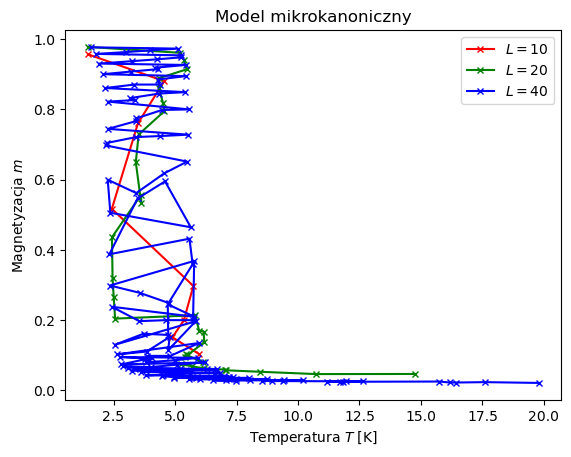

In [25]:
from matplotlib import pyplot as plt

colors = ["r", "g", "b"]

for results, side, color in zip(result_sets, sides, colors):
    xs = [result.temperature for result in results]
    ys = [result.magnetization_mean for result in results]

    plt.plot(xs, ys, f"{color}x-", markersize=5, label=f"$L={side}$")
    plt.xlabel("Temperatura $T$ [K]")
    plt.ylabel("Magnetyzacja $m$")
    plt.title("Model mikrokanoniczny")

plt.legend()
plt.show()

## Zadanie 2

In [30]:
@dataclass
class ExperimentResultCanonical:
    system_energy_mean: float
    magnetization_mean: float
    temperature: float

    @classmethod
    def from_io(cls, output: TextIO) -> ExperimentResultCanonical:
        lines = [line for line in output.readlines() if "=" in line]
        values = [line.split("=")[1].strip() for line in lines]
        return cls(*map(float, values))


def run_experiment_canonical(
    side: int = 10,
    temperature: float = 0,
    steps: int = 1000,
) -> ExperimentResultCanonical:
    out_buffer = run_experiment(side=side, temperature=temperature, steps=steps)
    return ExperimentResultCanonical.from_io(out_buffer)

In [31]:
run_experiment_canonical()

ExperimentResultCanonical(system_energy_mean=-200.0, magnetization_mean=1.0, temperature=0.0)

In [45]:
sides = [10, 20, 40]

temperatures = np.linspace(1.5, 4, 40)

result_sets = [
    [
        run_experiment_canonical(side=side, temperature=temperature)
        for temperature in temperatures
    ]
    for side in sides
]

array([1.5       , 1.63157895, 1.76315789, 1.89473684, 2.02631579,
       2.15789474, 2.28947368, 2.42105263, 2.55263158, 2.68421053,
       2.81578947, 2.94736842, 3.07894737, 3.21052632, 3.34210526,
       3.47368421, 3.60526316, 3.73684211, 3.86842105, 4.        ])

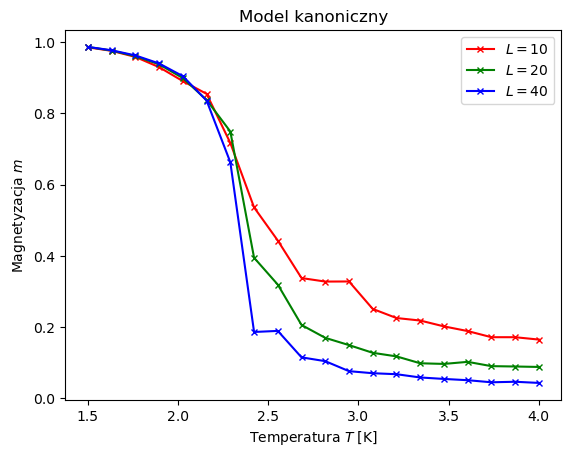

In [ ]:
from matplotlib import pyplot as plt

colors = ["r", "g", "b"]

for results, side, color in zip(result_sets, sides, colors):
    xs = [result.temperature for result in results]
    ys = [result.magnetization_mean for result in results]

    plt.plot(xs, ys, f"{color}x-", markersize=5, label=f"$L={side}$")
    plt.xlabel("Temperatura $T$ [K]")
    plt.ylabel("Magnetyzacja $m$")
    plt.title("Model kanoniczny")

plt.legend()
plt.show()